In [2]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
import numpy as np 
import matplotlib.pyplot as plt

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [5]:
x_train.shape

(50000, 32, 32, 3)

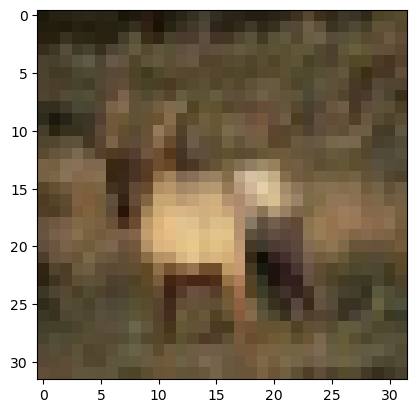

In [6]:
plt.imshow(x_train[3])

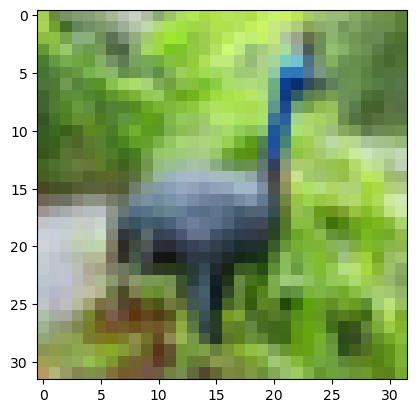

In [7]:
plt.imshow(x_train[6])

## Data Cleansing

In [8]:
## Dimention Reduction to make the nombre 0 to 1
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

In [9]:
## Knwoing the dimension, we have 10 possible outputs
len(np.unique(y_train))


10

In [10]:
num_class = len(np.unique(y_train))
# to categorical 10 classes in train & test
y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

In [11]:
#Showing "1" when is in one class
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## Normalization

In [12]:
## getting mean and std to get number from 0 to 1
mean = np.mean(x_train)
std = np.std(x_train)

In [13]:
#doing the normalization
x_train = (x_train - mean) / (std+1e-7) #getting a tiny add to avoid getting 0/0
x_test = (x_test - mean) / (std+1e-7)

## Creating Data Sets

In [14]:
#separating our training set in validation, training and test

(x_train, x_valid) = x_train[5000:] , x_train[:5000]
(y_train, y_valid) = y_train[5000:] , y_train[:5000]

print('x_train shape', x_train.shape)

print("train:" , x_train.shape[0])
print("validation:" , x_valid.shape[0])
print("test:" , x_test.shape[0])

x_train shape (45000, 32, 32, 3)
train: 45000
validation: 5000
test: 10000


## Model

In [15]:
filtter_base = 32
w_regularizer = 1e-4

In [16]:
 x_train.shape[1:]
#this shape is the inpout, images 32x32 in 3 layers

(32, 32, 3)

In [17]:
model = Sequential()

#Conv1
    #number of filters in convolution layer
model.add(Conv2D(filtter_base,(3,3), padding="same", kernel_regularizer=regularizers.l2(w_regularizer), input_shape = x_train.shape[1:]))
#this time the kernel size will be 3x3   #padding equal to the image, so "same" used
model.add(Activation("relu"))
#adding batch notmalization
model.add(BatchNormalization())

#Conv2
model.add(Conv2D(filtter_base,(3,3), padding="same", kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) # MaxPooling to reduce complex
model.add(Dropout(0.2)) #to reduce overfitting

#Conv3       #making the layer deeper (x2)
model.add(Conv2D(2*filtter_base,(3,3), padding="same", kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2)) 

#Conv4      
model.add(Conv2D(2*filtter_base,(3,3), padding="same", kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Dropout(0.3)) 

#Max Pooling every 2 convolution

#Conv5        #Even deeper
model.add(Conv2D(4*filtter_base,(3,3), padding="same", kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation("relu"))
model.add(BatchNormalization())

#Conv6      
model.add(Conv2D(4*filtter_base,(3,3), padding="same", kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Dropout(0.4)) 


#Flatten Clasification

# Making the result only to 1 dimention
model.add(Flatten())
model.add(Dense(num_class, activation="softmax")) #remenber softmax to a multiple classification solving

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

## Data Argumentation

In [18]:
#to get more images to train, images with differents views
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

## Model Compile

In [19]:
from tensorflow.keras import optimizers
#to get the optimizer Ada, neccesary in this case

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
             metrics=['accuracy'])                             #this optimizer get te momentum efficiently

## Callbacks

In [21]:
chekcpoint = ModelCheckpoint('my_best_model.hdf5',verbose=1,save_best_only=True, monitor = 'val_accuracy')

## Training

In [22]:
## This was the old hist

#hist = model.fit(x_train, y_train, batch_size=32,epochs=100,
#                validation_data=(x_valid,y_valid),
#                verbose=2,shuffle=True)

In [23]:
#We need to use a hist with the datagen data
hist = model.fit(datagen.flow(x_train, y_train, batch_size=128),
          callbacks=[chekcpoint], #using the data train under the batch size
          steps_per_epoch=x_train.shape[0] // 128, 
          epochs=120,
          verbose=2,
          validation_data=(x_valid, y_valid)
         )

Epoch 1/120


2023-03-21 15:47:14.274975: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_accuracy improved from -inf to 0.30120, saving model to my_best_model.hdf5
351/351 - 34s - loss: 2.2527 - accuracy: 0.3270 - val_loss: 2.1106 - val_accuracy: 0.3012 - 34s/epoch - 97ms/step
Epoch 2/120

Epoch 2: val_accuracy improved from 0.30120 to 0.48260, saving model to my_best_model.hdf5
351/351 - 23s - loss: 1.7437 - accuracy: 0.4314 - val_loss: 1.5993 - val_accuracy: 0.4826 - 23s/epoch - 66ms/step
Epoch 3/120

Epoch 3: val_accuracy improved from 0.48260 to 0.49460, saving model to my_best_model.hdf5
351/351 - 23s - loss: 1.5396 - accuracy: 0.4974 - val_loss: 1.4630 - val_accuracy: 0.4946 - 23s/epoch - 66ms/step
Epoch 4/120

Epoch 4: val_accuracy improved from 0.49460 to 0.54780, saving model to my_best_model.hdf5
351/351 - 23s - loss: 1.4257 - accuracy: 0.5347 - val_loss: 1.4026 - val_accuracy: 0.5478 - 23s/epoch - 66ms/step
Epoch 5/120

Epoch 5: val_accuracy improved from 0.54780 to 0.56280, saving model to my_best_model.hdf5
351/351 - 23s - loss: 1.3289 - accuracy

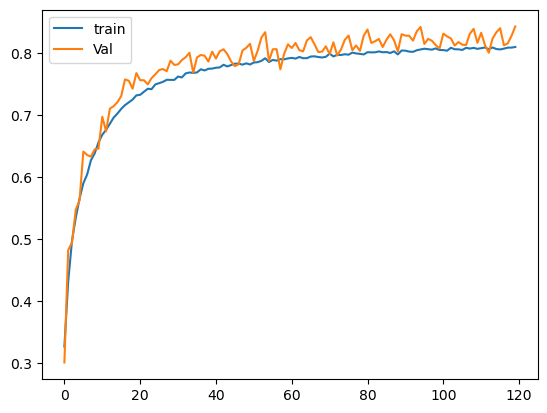

In [24]:
plt.plot(hist.history["accuracy"],label="train")
plt.plot(hist.history["val_accuracy"],label="Val")
plt.legend()
plt.show()

In [25]:
from keras.models import clone_model
model2 = clone_model(model)

In [26]:
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
               metrics=['accuracy'])  

In [31]:
model2.load_weights("/kaggle/working/my_best_model.hdf5")

In [32]:
model2.evaluate(x_test,y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.6473 - accuracy: 0.8322


[0.6473303437232971, 0.8321999907493591]